# Workshop unit-1
# Binary Classification with Neural Networks on the Census Income Dataset
**Name** PRIYADHARSHINI S

**Reg No** 212223240129

**Slot No** 4O1-1

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv('income.csv')

In [2]:
print(len(df))
df.head()

31978


,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,45,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,28,United-States,"less than or equal to 50,000"
1,24,Federal-gov,HS-grad,Never-married,Armed-Forces,Own-child,White,Male,0,0,40,United-States,"less than or equal to 50,000"
2,44,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,"greater than 50,000"
3,27,Private,9th,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,"less than or equal to 50,000"
4,20,Private,Some-college,Never-married,Sales,Not-in-family,White,Male,0,0,35,United-States,"less than or equal to 50,000"


In [3]:
df['age'].value_counts()

36    875
23    871
31    870
34    862
33    862
     ... 
83      6
88      3
85      3
86      1
87      1
Name: age, Length: 73, dtype: int64

In [4]:
df.columns

Index(['age', 'JobType', 'EdType', 'maritalstatus', 'occupation',
       'relationship', 'race', 'gender', 'capitalgain', 'capitalloss',
       'hoursperweek', 'nativecountry', 'SalStat'],
      dtype='object')

In [5]:
cat_cols  = ['JobType', 'EdType', 'maritalstatus', 'occupation', 'relationship']
cont_cols = ['age', 'hoursperweek']
y_col     = ['SalStat']

# Run the check
print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


In [6]:
# Convert categorical columns to category dtype
for col in cat_cols:
    df[col] = df[col].astype('category')

In [7]:
# Convert categorical columns to category dtype
for col in cat_cols:
    df[col] = df[col].astype('category')

# (Optional) Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)

df.head()

,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,31,Private,10th,Divorced,Craft-repair,Not-in-family,White,Male,0,0,38,United-States,"less than or equal to 50,000"
1,27,Private,Bachelors,Never-married,Tech-support,Not-in-family,White,Male,0,0,37,United-States,"less than or equal to 50,000"
2,42,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,7298,0,45,United-States,"greater than 50,000"
3,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,4,United-States,"less than or equal to 50,000"
4,30,Local-gov,Assoc-voc,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,"less than or equal to 50,000"


In [8]:
# 1. Number of categories for each categorical variable
cat_szs = [df[col].nunique() for col in cat_cols]

# 2. Create list of (category size, embedding size) tuples
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

print(cat_szs)
print(emb_szs)

[9, 16, 7, 15, 6]
[(9, 5), (16, 8), (7, 4), (15, 8), (6, 3)]


In [9]:
import numpy as np

cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1).astype('int8')

print(cats[:5])

[[ 4  0  0  3  1]
 [ 4  9  4 13  1]
 [ 4  9  2  4  0]
 [ 0 15  4  0  3]
 [ 2  8  2 11  0]]


In [10]:
import torch

cats = torch.tensor(cats, dtype=torch.int64)

print(cats.shape, cats.dtype)
print(cats[:5])

torch.Size([31978, 5]) torch.int64
tensor([[ 4,  0,  0,  3,  1],
        [ 4,  9,  4, 13,  1],
        [ 4,  9,  2,  4,  0],
        [ 0, 15,  4,  0,  3],
        [ 2,  8,  2, 11,  0]])


In [11]:
conts = np.stack([df[col].values for col in cont_cols], axis=1).astype('int64')

print(conts[:5])

[[31 38]
 [27 37]
 [42 45]
 [18  4]
 [30 40]]


In [12]:
conts = torch.tensor(conts, dtype=torch.float32)

print(conts.dtype)
print(conts[:5])

torch.float32
tensor([[31., 38.],
        [27., 37.],
        [42., 45.],
        [18.,  4.],
        [30., 40.]])


In [13]:
y = torch.tensor(df[y_col[0]].astype('category').cat.codes.values, dtype=torch.int64)

print(y.shape, y.dtype)
print(y[:10])

torch.Size([31978]) torch.int64
tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1])


In [14]:
# Suggested batch and test sizes
b = 30000  # training size
t = 5000   # test size

# Split categorical data
cats_train = cats[:b]
cats_test  = cats[b:b+t]

# Split continuous data
conts_train = conts[:b]
conts_test  = conts[b:b+t]

# Split labels
y_train = y[:b]
y_test  = y[b:b+t]

# Check shapes
print(cats_train.shape, conts_train.shape, y_train.shape)
print(cats_test.shape, conts_test.shape, y_test.shape)

torch.Size([30000, 5]) torch.Size([30000, 2]) torch.Size([30000])
torch.Size([1978, 5]) torch.Size([1978, 2]) torch.Size([1978])


In [15]:
torch.manual_seed(33)

In [16]:
import torch
import torch.nn as nn

class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [17]:
n_cont = len(cont_cols)
out_sz = len(df[y_col[0]].unique())

model = TabularModel(emb_szs, n_cont, out_sz, layers=[50], p=0.4)
print(model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(16, 8)
    (2): Embedding(7, 4)
    (3): Embedding(15, 8)
    (4): Embedding(6, 3)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=30, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [18]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(criterion)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [20]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(cats_train, conts_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

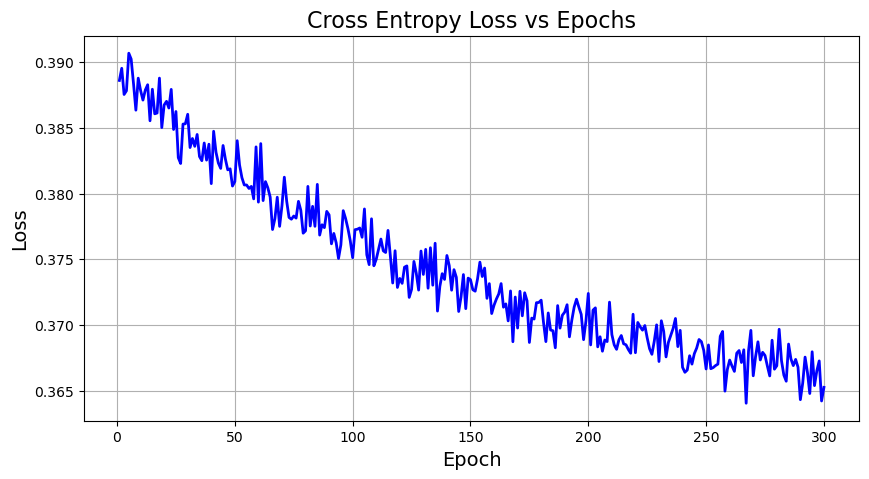

In [21]:
import matplotlib.pyplot as plt

loss_values = [loss.item() for loss in losses]

plt.figure(figsize=(10,5))
plt.plot(range(1, len(loss_values)+1), loss_values, color='blue', lw=2)
plt.title('Cross Entropy Loss vs Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.show()

In [22]:
with torch.no_grad():
    y_val = model(cats_test, conts_test)
    
    loss = criterion(y_val, y_test)

print(f'CE Loss: {loss.item():.8f}')

CE Loss: 0.38049635


In [23]:
y_pred_classes = torch.argmax(y_val, dim=1)

correct = 0

for i in range(len(y_test)):
    if y_pred_classes[i] == y_test[i]:
        correct += 1

accuracy = correct / len(y_test) * 100

print(f'{correct} out of {len(y_test)} = {accuracy:.2f}% correct')

1640 out of 1978 = 82.91% correct


In [24]:
def predict_new(model):
    model.eval()
    job_d = {'Private':0, 'Self-emp':1, 'Government':2, 'Other':3, 'Never-worked':4, 'Without-pay':5, 'Local-gov':6, 'State-gov':7, 'Federal-gov':8, 'Self-emp-inc':9, 'Self-emp-not-inc':10, '?':11, 'Child':12, 'Private-Other':13}
    edu_d = {str(i):i-3 for i in range(3,17)}
    marital_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    occ_d = {'Sales':0, 'Exec-managerial':1, 'Tech-support':2, 'Craft-repair':3, 'Other-service':4, 'Prof-specialty':5, 'Handlers-cleaners':6, 'Machine-op-inspct':7, 'Adm-clerical':8, 'Transport-moving':9, 'Farming-fishing':10, 'Protective-serv':11, 'Priv-house-serv':12, 'Armed-Forces':13}
    rel_d = {'Not-in-family':0, 'Husband':1, 'Wife':2, 'Own-child':3, 'Other-relative':4, 'Unmarried':5}
    age = float(input("What is the person's age? (18-90) "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edu = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    job = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hours = float(input("How many hours/week are worked? (20-90) "))
    cat_input = [
        job_d.get(job,0),
        edu_d.get(str(edu),0),
        marital_d.get(mar,0),
        occ_d.get(occ,0),
        0
    ]
    cats_tensor = torch.tensor([cat_input], dtype=torch.int64)
    cont_tensor = torch.tensor([[age, hours]], dtype=torch.float32)
    with torch.no_grad():
        pred = model(cats_tensor, cont_tensor)
        label = torch.argmax(pred, dim=1).item()
    print(f"\nThe predicted label is {label}")

In [25]:
predict_new(model)

What is the person's age? (18-90) 19
What is the person's sex? (Male/Female) Female
What is the person's education level? (3-16) 10
What is the person's marital status? Not Married
What is the person's workclass? High Tech
What is the person's occupation? Business
How many hours/week are worked? (20-90) 20

The predicted label is 1
